# Enhanced rawMSA NN Gray2018

Here I implement the additional features that I develop in try to replicate the results in enhaced_simple_nn using an adaptation of the rawMSA approach.

## Original dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
import joblib
from Bio import SeqIO

df = pd.read_csv('../dataset/gray2018/dmsTraining_2017-02-20.csv')

# some of the studies in the training set were excluded from training in the original paper
# I also remove here proteins without a structure
excluded_studies = ['Brca1_E3', 'Brca1_Y2H', 'E3_ligase']
for study in excluded_studies:
    df = df[df.dms_id != study]

# obtain a dictionary with the uniprot sequences for each protein
sequences = {}
for basename in set(df.uniprot_id):
    curr_seq = str(list(SeqIO.parse('../processing/gray2018/uniprot_sequences/' + basename + '.fasta', 'fasta'))[0].seq)
    sequences[basename] = curr_seq

len_before = len(df)
        
# remove inconsistencies with the uniprot sequences
index_in_range = pd.Series([row.position - 1 < len(sequences[row.uniprot_id]) for _, row in df.iterrows()], index=df.index)
df = df[index_in_range]
correct_aa1 = pd.Series([row.aa1 == sequences[row.uniprot_id][row.position - 1] for _, row in df.iterrows()], index=df.index)
df = df[correct_aa1]

# check that there are no more inconsistencies
for protein in set(df.uniprot_id.values):
    curr_df = df[df.uniprot_id == protein]
    for position in set(curr_df.position.values):
        aa1_set = set(curr_df[curr_df.position == position].aa1)
        assert len(aa1_set) == 1
        curr_aa1 = aa1_set.pop()
        seq_index = position - 1
        curr_real_res = sequences[protein][seq_index]
        assert curr_aa1 == curr_real_res
                
# print how many entries have been removed (the false values)
len_after = len(df)
print('Removed entries for wrong mapping:', len_before - len_after)

# this df will contain different normalizations of the outputs, and pointers to the protein and dataset of origin
effect_df = pd.DataFrame({'protein': df.protein,
                          'dms_id': df.dms_id,
                          'position': df.position,
                          'aa1': df.aa1,
                          'aa2': df.aa2,
                          'uniprot_id': df.uniprot_id,
                          'pdb_id': df.pdb_id,
                          'pdb_chain_id': df.pdb_chain_id,
                          'reported_fitness': df.reported_fitness,
                          'scaled_effect1': df.scaled_effect1})

# quantile normalization with removal of the wt score
# the idea was taken from Munro2020
for dataset in set(effect_df.dms_id):
    curr_df = effect_df[effect_df.dms_id == dataset]
    scaler = QuantileTransformer(n_quantiles=100)
    x = np.array(curr_df.reported_fitness).reshape(-1,1)
    x_scaled = scaler.fit_transform(x) - scaler.transform(np.zeros((1,1)))
    effect_df.loc[(effect_df.dms_id == dataset) , 'scaled_effect8'] = x_scaled
    
# random output for testing
effect_df['random_scaled_effect8'] = np.random.permutation(effect_df.scaled_effect8)

# separate numerical and categorical features
is_feature = [#'aa1',
              #'aa2',
              'WT_Mut', 
              'aa1_polarity',
              'aa2_polarity',
              'aa1_PI', 
              'aa2_PI',
              'deltaPI', 
              'aa1_weight',
              'aa2_weight', 
              'deltaWeight', 
              'aa1vol', 
              'aa2vol', 
              'deltavolume',
              'Grantham', 
              'aa1_psic', 
              'aa2_psic', 
              'delta_psic', 
              'accessibility',
              'dssp_sec_str', 
              'phi_psi_reg', 
              'delta_solvent_accessibility',
              'b_factor', 
              'mut_msa_congruency',
              'mut_mut_msa_congruency',
              'selection_coefficient',
              'evolutionary_coupling_avg', 
              'evolutionary_coupling_prop',
              'evolutionary_coupling_avg_norm']

is_categorical_feature = [#'aa1',
                          #'aa2',
                          'aa1_polarity',
                          'aa2_polarity',
                          'WT_Mut', 
                          'dssp_sec_str',
                          'phi_psi_reg', 
                         ]

is_numerical_feature = [feature for feature in is_feature if feature not in is_categorical_feature]

x_numerical_list = []
x_numerical_feature_names_list = []
for column in df[is_numerical_feature]:
    x_numerical_list.append(df[column])
    x_numerical_feature_names_list.append(column)
x_numerical = np.array(x_numerical_list).T
x_numerical_feature_names = np.array(x_numerical_feature_names_list).T

# categorical to one-hot encoding
x_categorical = np.array(df[is_categorical_feature])
enc = OneHotEncoder(sparse=False)
to_concat = []
to_concat_feature_names = []
for column, name in zip(x_categorical.T, is_categorical_feature):
    column_one_hot = enc.fit_transform(column.reshape(-1,1))
    to_concat.append(column_one_hot)
    to_concat_feature_names.append(np.array([name + '_onehot_dim_' + str(i) for i in range(column_one_hot.shape[1])]))
x_onehot = np.concatenate(to_concat, axis=1)
x_onehot_feature_names = np.concatenate(to_concat_feature_names)

x_original = np.concatenate([x_onehot, x_numerical], axis=1)
x_original_feature_names = np.concatenate([x_onehot_feature_names, x_numerical_feature_names])

x_original.shape, len(effect_df), len(df)

Removed entries for wrong mapping: 58


((22280, 472), 22280, 22280)

## New features

In [126]:
from Bio import AlignIO
from sklearn.preprocessing import OrdinalEncoder
from Bio.Data import IUPACData

symbols = np.expand_dims(list(IUPACData.extended_protein_letters + "-"), axis=1)
msa_depth = 100

# encoder for the msa
enc = OrdinalEncoder()
enc.fit(symbols)

lookup_table = dict()
for uniprot_id in set(effect_df.uniprot_id):
    lookup_table[uniprot_id] = dict()
    align = np.array(AlignIO.read('../processing/gray2018/hhblits/' + uniprot_id + '.aln', "fasta"))
    align_vec = []
    for column_in in align.T:
        column_out = enc.transform(np.expand_dims(column_in, axis=1)).flatten()
        align_vec.append(column_out)
    # add 1 since I reserve 0 for missing value
    align_vec = np.array(align_vec).T + 1
    lookup_table[uniprot_id]['align_vec'] = align_vec

x_additional = []
for _, row in effect_df.iterrows():
    # msa
    column_vec = lookup_table[row.uniprot_id]['align_vec'][:msa_depth, row.position - 1]
    pad_depth = msa_depth - column_vec.shape[0]
    column_vec = np.pad(column_vec, (0,pad_depth))
    assert column_vec.shape == (msa_depth,)
    # aa1, aa2
    aa1 = enc.transform(np.expand_dims(row.aa1, axis = (0,1))).flatten() + 1
    aa2 = enc.transform(np.expand_dims(row.aa2, axis = (0,1))).flatten() + 1
    assert column_vec[0] == aa1
    # row conbstruction
    curr_row = np.concatenate([column_vec, aa1, aa2])
    x_additional.append(curr_row)

x_additional = np.array(x_additional)

x_additional.shape, x_original.shape, effect_df.shape

((22280, 102), (22280, 472), (22280, 12))

In [223]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy import stats
import datetime
import os
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

np.random.seed(1)
tf.random.set_seed(1)

!rm -rf ./logs/ 
tf.keras.backend.clear_session()


def create_model(msa_depth=msa_depth):
    # common branch
    inputs = tf.keras.Input(shape=(msa_depth+2,))
    x_msa = tf.keras.layers.Lambda(lambda x : x[:,:msa_depth])(inputs)
    x_aa = tf.keras.layers.Lambda(lambda x : x[:,msa_depth:])(inputs)
    # msa branch
    x_msa = tf.keras.layers.Embedding(input_dim=28, output_dim=5)(x_msa)
    x_msa = tf.keras.layers.Conv1D(filters=5, kernel_size=5, activation='relu', padding='same', data_format='channels_last')(x_msa)
    x_msa = tf.keras.layers.Dropout(0.4)(x_msa)
    x_msa = tf.keras.layers.MaxPooling1D(pool_size=15, data_format='channels_last')(x_msa)
    x_msa = tf.keras.layers.Conv1D(filters=5, kernel_size=5, activation='relu', padding='same', data_format='channels_last')(x_msa)
    x_msa = tf.keras.layers.Dropout(0.4)(x_msa)
    x_msa = tf.keras.layers.MaxPooling1D(pool_size=5, data_format='channels_last')(x_msa)
    x_msa = tf.keras.layers.Flatten()(x_msa)
    ## aa branch
    x_aa = tf.keras.layers.Embedding(input_dim=28, output_dim=5)(x_aa)
    x_aa = tf.keras.layers.Flatten()(x_aa)
    # common branch
    x = tf.keras.layers.Concatenate()([x_msa, x_aa])
    x = tf.keras.layers.Dense(20, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(20, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    outputs = tf.keras.layers.Dense(1, activation='linear', name='output')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mlp')
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.rank
    model.compile(optimizer=optimizer, loss=loss)
    return model


def lopo_plots_and_correlation(x, df, target):
    input_shape = x.shape[1:]
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.compat.v1.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    y = np.array(df[target])
    lopo = LeaveOneGroupOut()
    max_spearman, min_spearman = -100, 100 # reversed since I want them to be updated
    results = []
    for train, val in lopo.split(x, groups=df.protein):
        imp = SimpleImputer(strategy='mean')
        scaler = MinMaxScaler()
        imp.fit(x[train])
        scaler.fit(x[train][:,-1].reshape(-1,1)) #last is num_sequences
        x_scaled = np.copy(x)
        #x_scaled[:,-1] = scaler.transform(x[:,-1].reshape(-1,1)).flatten()
        x_imputed = imp.transform(x_scaled)
        regr = create_model()
        regr.summary()
        regr.fit(x_imputed[train], y[train], epochs=10, validation_data=(x_imputed[val], y[val]), callbacks=[tensorboard_callback])
        curr_protein_tested = list(set(df.protein.iloc[val]))
        assert len(curr_protein_tested) == 1
        print('Protein:', curr_protein_tested[0])
        y_pred = regr.predict(x_imputed[val])
        for dataset in list(set(df.dms_id.iloc[val])):
            print('Dataset:', dataset)
            y_pred_to_show, y_test_to_show = y_pred[df.dms_id.iloc[val] == dataset].flatten(), y[val][df.dms_id.iloc[val] == dataset].flatten()
            curr_spearman = stats.spearmanr(y_pred_to_show, y_test_to_show)[0]
            max_spearman, min_spearman = max(max_spearman, curr_spearman), min(min_spearman, curr_spearman)
            results.append([dataset, curr_spearman, [y_pred_to_show, y_test_to_show]])
            print('spearman:', curr_spearman)           
            plt.close()
            sns.scatterplot(x=y_test_to_show, y=y_pred_to_show, s=10)
            plt.show()
        tf.keras.backend.clear_session()
        del regr
    print('Overall min spearman:', min_spearman, '\nOverall max spearman', max_spearman)
    result = pd.DataFrame(results, columns=['dataset', 'spearman', 'full_results']) 
    return results

Model: "mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 102)]        0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 100)          0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 5)       140         lambda[0][0]                     
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 5)       130         embedding[0][0]                  
________________________________________________________________________________________________

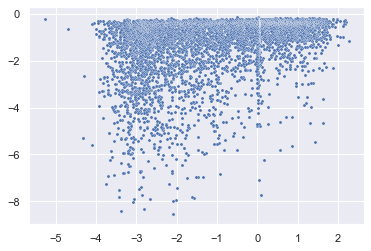

Model: "mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 102)]        0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 100)          0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 5)       140         lambda[0][0]                     
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 5)       130         embedding[0][0]                  
________________________________________________________________________________________________

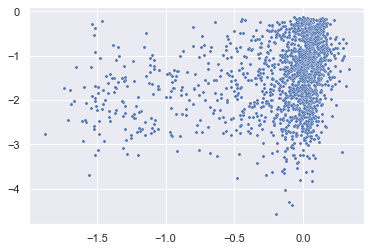

Model: "mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 102)]        0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 100)          0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 5)       140         lambda[0][0]                     
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 5)       130         embedding[0][0]                  
________________________________________________________________________________________________

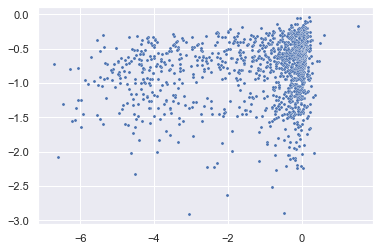

Model: "mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 102)]        0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 100)          0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 5)       140         lambda[0][0]                     
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 5)       130         embedding[0][0]                  
________________________________________________________________________________________________

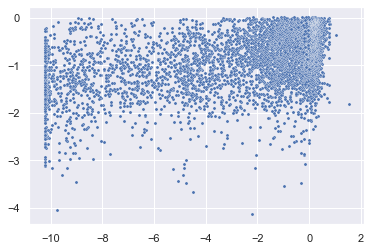

Model: "mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 102)]        0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 100)          0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 5)       140         lambda[0][0]                     
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 5)       130         embedding[0][0]                  
________________________________________________________________________________________________

KeyboardInterrupt: 

In [226]:
results = lopo_plots_and_correlation(x_additional, effect_df, 'reported_fitness')